LSTM应用股票市场初探
https://www.jianshu.com/p/8122f866436b

In [11]:
# 导入包 
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.preprocessing import scale 
from keras.layers import Input, Dense, LSTM, merge 
from keras.models import Model 
import pandas as pd 
import numpy as np 
import talib as ta 
import tushare as ts 
import matplotlib.pyplot as plt 
from matplotlib import rc 

rc('mathtext', default='regular') 
import seaborn as sns 
sns.set_style('white') 
from matplotlib import dates 
import matplotlib as mpl 
%matplotlib inline 
#plt.rcParams["figure.figsize"] = (20,10)


In [12]:
# 基础参数配置 
class conf: 
    instrument = '600600' #股票代码 
    #设置用于训练和回测的开始/结束日期 
    start_date = '2017-01-01' 
    split_date = '2017-10-01' 
    end_date = '2018-03-01' 
    fields = ['close', 'open', 'high', 'low','volume','amount'] 
    # features 
    seq_len = 30 #每个input的长度 
    batch = 100 #整数，指定进行梯度下降时每个batch包含的样本数,训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步


In [13]:
# 数据导入以及初步处理 
data = ts.get_k_data(conf.instrument, conf.start_date, conf.end_date) 
del data["code"] 
data["amount"] = data["close"] * data["volume"] 
data['return'] = data['close'].shift(-5) / data['open'].shift(-1) - 1 #计算未来5日收益率（未来第五日的收盘价/明日的开盘价） 
data.dropna(inplace=True) 
datatime = data['date'][data.date>=conf.split_date] #记录predictions的时间，回测要用 
data['return'] = data['return'].apply(lambda x:np.where(x>=0.2,0.2,np.where(x>-0.2,x,-0.2))) #去极值 
data['return'] = data['return'] * 10 # 适当增大return范围，利于LSTM模型训练 
data.reset_index(drop=True, inplace=True) 
scaledata = data[conf.fields] 
traindata = data[data.date < conf.split_date]

# print(len(data), len(traindata))
# print(traindata)
# print(scaledata)

In [14]:
# 数据处理：设定每个input（30 time series×6features）以及数据标准化 
train_input = [] 
train_output = [] 
test_input = [] 
test_output = [] 
for i in range(conf.seq_len-1, len(traindata)): 
    a = scale(scaledata[i+1-conf.seq_len:i+1]) 
    # print("~~~~~~~~~~~~~~~~~~~~~~")
    # print(a.shape)
    train_input.append(a) 
    c = data['return'][i] 
    # c = data['return'][i+1-conf.seq_len:i+1]
    train_output.append(c) 
    # print(np.shape(train_input), " xxxx ", np.shape(train_output), " ; ", train_output)

for j in range(len(traindata), len(data)): 
    b = scale(scaledata[j+1-conf.seq_len:j+1]) 
    test_input.append(b) 
    c = data['return'][j] 
    test_output.append(c) 

# LSTM接受数组类型的输入 
train_x = np.array(train_input) 
train_y = np.array(train_output) 
test_x = np.array(test_input) 
test_y = np.array(test_output)

# print("=========================================")
# print("train_input shape : ", np.shape(train_input))
# print("train_output shape: ", np.shape(train_output))

# print("test_input shape : ", np.shape(test_input))
# print("test_output shape: ", np.shape(test_output))

# print("train_x: ", train_x.shape, "test_x shape: ", test_x.shape)
# print("------------------------------------------")

In [15]:
# 自定义激活函数
import tensorflow as tf
def atan(x): 
    return tf.atan(x)

In [16]:
# 构建神经网络层 1层LSTM层+3层Dense层 
# 用于1个输入情况 
lstm_input = Input(shape=(30,6), name='lstm_input') 
lstm_output = LSTM(128, activation=atan, dropout=0.2, recurrent_dropout=0.1)(lstm_input) 
Dense_output_1 = Dense(64, activation='linear')(lstm_output) 
Dense_output_2 = Dense(16, activation='linear')(Dense_output_1) 
predictions = Dense(1, activation=atan)(Dense_output_2) 
model = Model(inputs=lstm_input, outputs=predictions) 
model.compile(optimizer='adam', loss='mse', metrics=['mse']) 
model.fit(train_x, train_y, batch_size=conf.batch, epochs=10, verbose=2)

Epoch 1/10
 - 1s - loss: 0.0665 - mean_squared_error: 0.0665
Epoch 2/10
 - 0s - loss: 0.0676 - mean_squared_error: 0.0676
Epoch 3/10
 - 0s - loss: 0.0628 - mean_squared_error: 0.0628
Epoch 4/10
 - 0s - loss: 0.0539 - mean_squared_error: 0.0539
Epoch 5/10
 - 0s - loss: 0.0530 - mean_squared_error: 0.0530
Epoch 6/10
 - 0s - loss: 0.0499 - mean_squared_error: 0.0499
Epoch 7/10
 - 0s - loss: 0.0528 - mean_squared_error: 0.0528
Epoch 8/10
 - 0s - loss: 0.0541 - mean_squared_error: 0.0541
Epoch 9/10
 - 0s - loss: 0.0515 - mean_squared_error: 0.0515
Epoch 10/10
 - 0s - loss: 0.0506 - mean_squared_error: 0.0506


In [17]:
# 预测
print(test_x.shape)
predictions = model.predict(test_x)

(93, 30, 6)


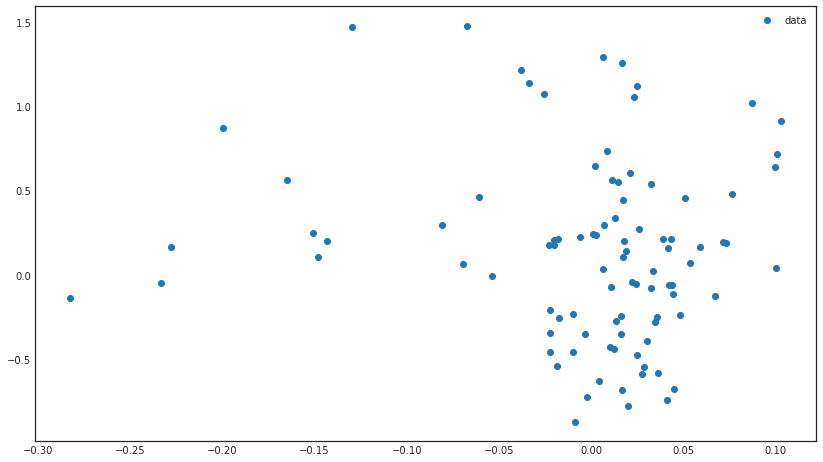

In [18]:
# 预测值和真实值的关系 
data1 = test_y 
data2 = predictions 
fig, ax = plt.subplots(figsize=(14, 8)) 
ax.plot(data2,data1, 'o', label="data") 
ax.legend(loc='best')

In [19]:
# 如果预测值>0,取为1；如果预测值<=0,取为-1.为回测做准备 
for i in range(len(predictions)): 
    if predictions[i]>0: 
        predictions[i]=1 
    elif predictions[i]<=0: 
        predictions[i]=-1

In [10]:
# 将预测值与时间整合作为回测数据 
cc = np.reshape(predictions,len(predictions), 1) 
databacktest = pd.DataFrame() 
databacktest['date'] = datatime 
databacktest['direction'] = np.round(cc)